In [119]:
import torch
import time
import random
import subprocess

import numpy as np
import matplotlib.pyplot as plt

from typing import List
from tqdm import tqdm

In [105]:
K = 3

In [106]:
def read_matrix_from_txt(path: str) -> List[List[int]]:
    matrix = []
    
    # Open the file and read line by line
    with open(path, 'r') as file:
        for line in file:
            # Strip any extra spaces or newlines and split the line into numbers
            row = list(map(int, line.strip().split()))
            # Append the row to the matrix
            matrix.append(row)
    
    return matrix


def generate_and_save_matrix(n: int, file_path: str = "matrix.txt", min_val=0, max_val=10):
    matrix = [[random.randint(min_val, max_val) for _ in range(n)] for _ in range(n)]
    
    # Save the matrix to a .txt file
    with open(file_path, 'w') as file:
        for row in matrix:
            file.write(' '.join(map(str, row)) + '\n')


def mean_execution_time(K):
    def decorator(func):
        def wrapper(*args, **kwargs):
            total_time = 0
            for _ in range(K):
                start_time = time.time()  # Start time
                func(*args, **kwargs)     # Execute the function
                total_time += time.time() - start_time  # Track the elapsed time
            mean_time = total_time / K
            return mean_time
        return wrapper
    return decorator

In [146]:
@mean_execution_time(K=K)
def python_multiplication(path: str, n: int):    
    matrix = read_matrix_from_txt(path)

    result = [[0 for x in range(n)] for y in range(n)] 

    for i in range(n):
        for j in range(n):
            for k in range(n):
                result[i][j] += matrix[i][k] * matrix[k][j]

@mean_execution_time(K=K)
def numpy_multiplication(path: str, n: int) -> float:
    matrix = read_matrix_from_txt(path)
    matrix = np.array(matrix)

    _ = matrix @ matrix


@mean_execution_time(K=K)
def torch_multiplication(path: str, n: int) -> float:
    matrix = read_matrix_from_txt(path)
    matrix = torch.tensor(matrix)

    _ = matrix @ matrix

@mean_execution_time(K=K)
def c_multiplication(path: str, n: int) -> float:
    subprocess.run(["./mul", str(n), path])


@mean_execution_time(K=1)
def mpi_multiplication(path: str, n: int, np: int) -> float:
    subprocess.run(["mpirun", "-np", str(np), "./mpi_mul", path, str(n)])


In [ ]:
START = 10
END = 1_000
STEP = 10
PATH = "matrix.txt"

results = {}
for n in tqdm(range(START, END, STEP)):
    results[n] = []

    generate_and_save_matrix(n=n, file_path=PATH)

    results[n].append(
        numpy_multiplication(path=PATH, n=n)
    )

    results[n].append(
        torch_multiplication(path=PATH, n=n)
    )

    results[n].append(
        c_multiplication(path=PATH, n=n)
    )

    results[n].append(
        mpi_multiplication(path=PATH, n=n, np=2)
    )

    results[n].append(
        mpi_multiplication(path=PATH, n=n, np=4)
    )

100%|██████████| 99/99 [04:33<00:00,  2.76s/it]


In [148]:
measurements = np.array(list(results.values()))

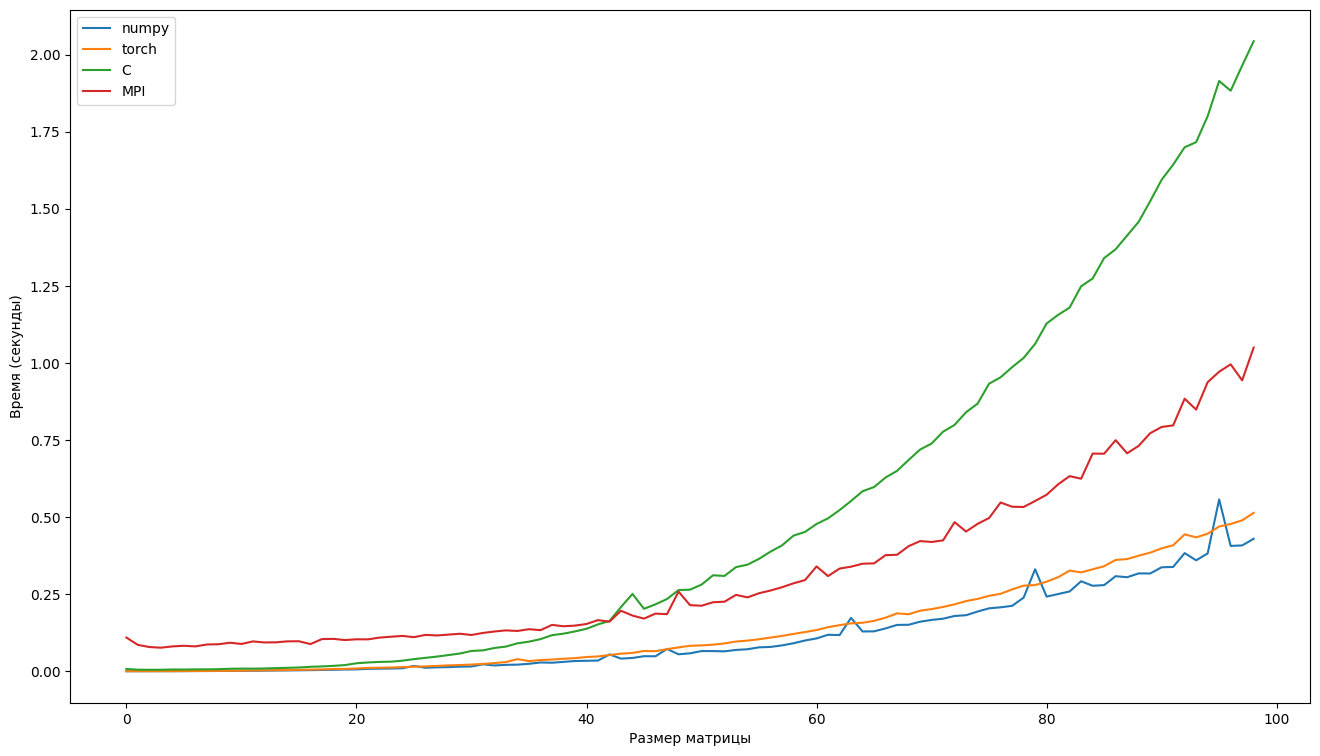

In [155]:
plt.subplots(figsize=(16, 9))

plt.plot(measurements[:, 0], label="numpy")
plt.plot(measurements[:, 1], label="torch")
plt.plot(measurements[:, 2], label="C")
plt.plot(measurements[:, 3], label="MPI")

plt.xlabel("Размер матрицы")
plt.ylabel("Время (секунды)")

plt.legend()
plt.show()